# Modelo de tarifación Airbnb en New York

Iteració previa Nov 3, 2020

Modificado May 4, 2021

* [Adquisición Datos](#Adquisición-Datos)
* [Entrenamiento y Testing](#Entrenamiento-y-Testing)
* [Descriptivo](#Descriptivo)
* [Normalizando](#Normalizando)
* [Separando caracteristicas y etiquetas](#Separando-caracteristicas-y-etiquetas)
* [El modelo](#El-modelo)
    * [Arquitectura](#Arquitectura)
    * [Entrenamiento](#Entrenamiento)
    * [Predicciones](#Predicciones)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models, layers, optimizers, regularizers
from numpy.random import seed
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
import math
import numpy as np
seed(123)
print(tf.__version__)

2.4.0


In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows= None

## Adquisición Datos

In [3]:
dataset=pd.read_csv('Listings_clean.csv')

In [4]:
dataset=dataset.dropna()
print('El dataset de entrada contiene', len(dataset.columns), 'columnas', 'y', len(dataset), 'filas')

El dataset de entrada contiene 39 columnas y 35300 filas


In [5]:
dataset.dtypes

Unnamed: 0                          int64
id                                  int64
host_is_superhost                 float64
host_listings_count               float64
host_has_profile_pic              float64
host_identity_verified            float64
latitude                          float64
longitude                         float64
accommodates                        int64
bedrooms                          float64
beds                              float64
price                             float64
minimum_nights                      int64
maximum_nights                      int64
has_availability                    int64
availability_30                     int64
number_of_reviews                   int64
instant_bookable                    int64
calculated_host_listings_count      int64
t_bathrooms                       float64
am_wifi                             int64
am_air conditioning                 int64
am_kitchen                          int64
am_parking                        

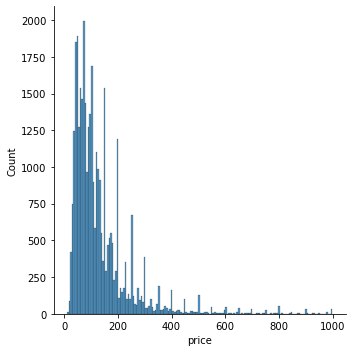

In [6]:
sns.displot(dataset['price'])
plt.show()

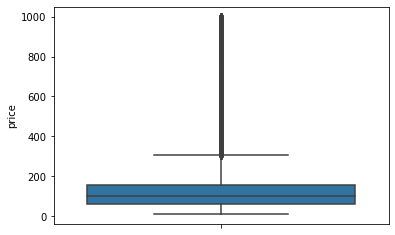

In [7]:
sns.boxplot(y=dataset['price'])
plt.show()

In [8]:
dataset['price'].describe()

count    35300.000000
mean       131.916289
std        115.642213
min         10.000000
25%         61.000000
50%        100.000000
75%        159.000000
max        999.000000
Name: price, dtype: float64

In [9]:
dataset=dataset[(dataset['price']>0)&(dataset['price']<600)]

In [10]:
dataset.head(3)

,Unnamed: 0,id,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,number_of_reviews,instant_bookable,calculated_host_listings_count,t_bathrooms,am_wifi,am_air conditioning,am_kitchen,am_parking,am_patio,am_barbecue,am_outdoor,am_games,am_soap,am_shampoo,apartment,house,other,room,entire home/apt,private room,shared room,private,shared
0,0,2595,0.0,6.0,1.0,1.0,40.75356,-73.98559,2,1.0,1.0,150.0,30,1125,1,30,48,0,3,1.0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0
1,1,3831,0.0,1.0,1.0,1.0,40.68494,-73.95765,3,1.0,1.0,76.0,1,730,1,1,396,0,1,1.0,1,1,1,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
2,2,5121,0.0,1.0,1.0,1.0,40.68535,-73.95512,2,1.0,1.0,60.0,30,730,1,30,50,0,1,1.0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0


In [11]:
dataset=dataset.drop(['Unnamed: 0', 'id'], axis=1)

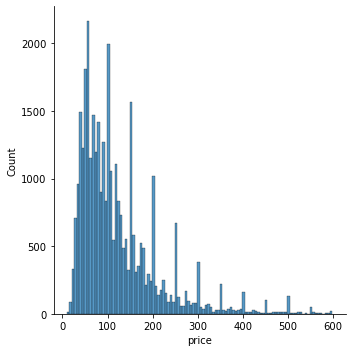

In [12]:
sns.displot(dataset['price'])
plt.show()

In [13]:
dataset['price']=np.log(dataset['price'])

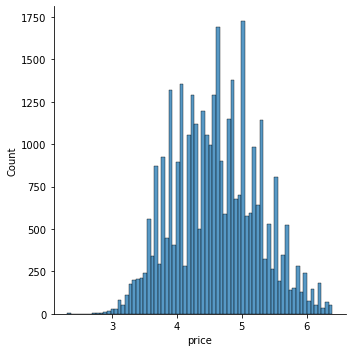

In [14]:
sns.displot(dataset['price'])
plt.show()

## Entrenamiento y Testing

In [15]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [16]:
train_dataset.head(6)

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,price,minimum_nights,maximum_nights,has_availability,availability_30,number_of_reviews,instant_bookable,calculated_host_listings_count,t_bathrooms,am_wifi,am_air conditioning,am_kitchen,am_parking,am_patio,am_barbecue,am_outdoor,am_games,am_soap,am_shampoo,apartment,house,other,room,entire home/apt,private room,shared room,private,shared
35807,0.0,2.0,1.0,0.0,40.73698,-73.95737,6,3.0,3.0,5.749393,3,1125,1,1,0,0,1,3.0,1,1,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0
15344,0.0,1.0,1.0,1.0,40.77264,-73.95727,2,1.0,1.0,5.010635,30,1125,1,0,1,1,1,1.0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
1597,1.0,1.0,1.0,1.0,40.80352,-73.96551,1,1.0,1.0,5.010635,30,1125,1,29,36,0,1,1.0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0
17036,0.0,1.0,1.0,1.0,40.73925,-74.00162,3,1.0,1.0,4.753590,30,90,1,0,15,0,1,1.0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
10735,1.0,2.0,1.0,1.0,40.71224,-73.96240,6,2.0,2.0,5.273000,2,20,1,0,60,0,2,1.0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0
7123,0.0,1.0,1.0,1.0,40.62152,-73.99363,4,1.0,1.0,4.574711,30,1125,1,0,94,0,1,1.0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0


## Normalizando

In [17]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [18]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# Separando caracteristicas y etiquetas

In [19]:
train_labels = normed_train_data.pop('price')
test_labels = normed_test_data.pop('price')

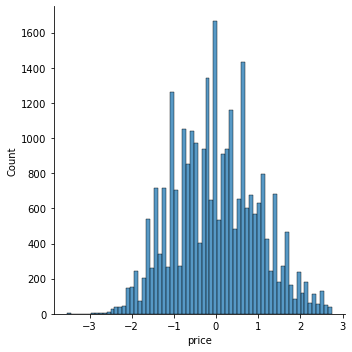

In [20]:
sns.displot(train_labels)
plt.show()

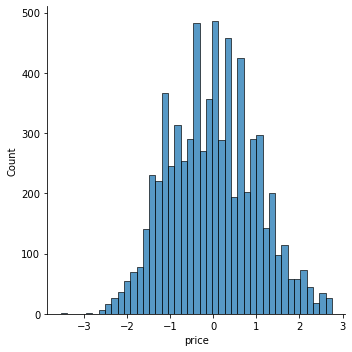

In [21]:
sns.displot(test_labels)
plt.show()

# El modelo

### Arquitectura

Ensayo 1: 256, dp 0.3, 128, dp 0.1, 32, 1. Todas activacion relu

Ensayo 1: 512, dp 0.1, 128, dp 0.1, 32, 1. Todas activacion relu

Ensayo 1: 512, dp 0.1, 256, dp 0.1, 32, 1. Todas activacion relu

Ensayo 1: 512, dp 0.1, 256, dp 0.1, 32, 1. Todas activacion relu adam 0.0001

Ensayo 1: 128 dp 0.1, 64, 1. Todas activacion relu adam 0.00001

Ensayo 1: 64 dp 0.1, 64, 1. Todas activacion relu adam 0.00001

Ensayo 1: 128 dp 0.3, 64, 1. Todas activacion relu adam 0.00001 Valores inferiores a 400

Ensayo 1: 256 dp 0.3, 64, 1. Todas activacion relu adam 0.00001 Valores inferiores a 400 Por ahora la mejr


Ensayo 1: 256 dp 0.3, 64, 1. Todas activacion relu adam 0.00001 Valores inferiores a 600


Ensayo 1: 256 dp 0.3, 256, 1. Todas activacion relu adam 0.00001 Valores inferiores a 600

Ensayo 1: 512 dp 0.3, 256, 1. Todas activacion relu adam 0.00001 Valores inferiores a 600

Ensayo 1: 512 dp 0.1, 256, 1. Todas activacion relu adam 0.00001 Valores inferiores a 600

Ensayo 1: 512 dp 0.1, 256,128, 1. Todas activacion relu adam 0.00001 Valores inferiores a 600 buen ajuste pero hay un punto que la prediccion es muy alta :(

Ensayo 1: 512 dp 0.1, 256,32, 1. Todas activacion relu adam 0.00001 Valores inferiores a 600. es necesario disminuir la variazan

In [22]:
# ,kernel_regularizer=regularizers.l2(0.05)
# La mejor que llevo es 512, 256, 32, dropout 0.1 y sin regularizador
def build_model():  
  model = keras.Sequential([
    layers.Dense(512, activation='relu',input_shape=[len(normed_train_data.keys())]),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  optimizer=Adam(0.00001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [23]:
model = build_model()

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               18944     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 158,529
Trainable params: 158,529
Non-trainable params: 0
_________________________________________________________________


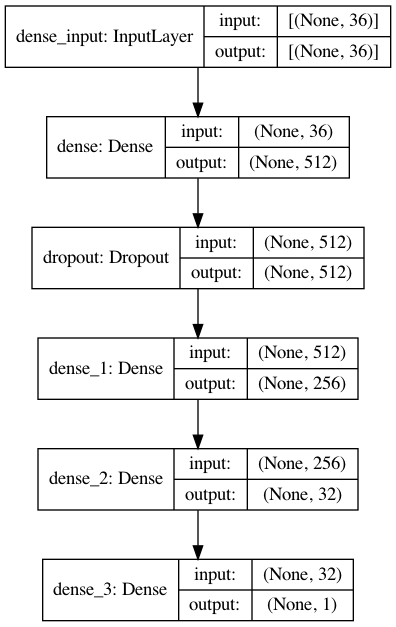

In [25]:
plot_model(model, to_file='regresion_model_keras.png', show_shapes=True)

In [26]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.7880004 ],
       [-0.4666443 ],
       [-0.33854622],
       [-0.40194517],
       [-0.49913427],
       [-0.3023389 ],
       [-0.42375916],
       [-0.39436692],
       [-0.4194611 ],
       [-0.42028517]], dtype=float32)

### Entrenamiento

In [27]:
# Display training progress by printing a single dot for each completed epoch
time_start = time.time()

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 150

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

time_end = time.time()
print(f"\nTiempo de ejecución: {round((time_end - time_start)/60,1)} minutos")


....................................................................................................
..................................................
Tiempo de ejecución: 4.5 minutos


In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
145,0.281369,0.406152,0.281369,0.385858,0.434682,0.385858,145
146,0.280443,0.406244,0.280443,0.388689,0.435233,0.388689,146
147,0.279544,0.404957,0.279544,0.389307,0.435116,0.389307,147
148,0.279707,0.405054,0.279707,0.392158,0.435178,0.392158,148
149,0.277381,0.403774,0.277381,0.397875,0.437761,0.397875,149


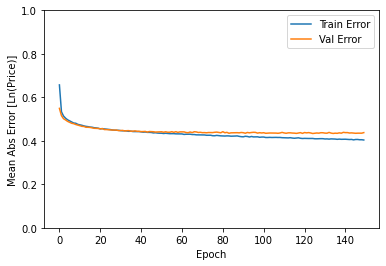

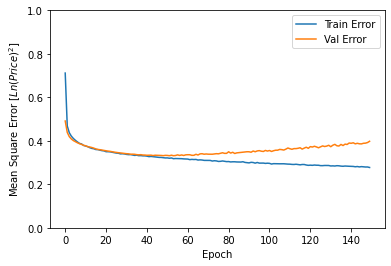

In [29]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Ln(Price)]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0.0,1])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$Ln(Price)^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0.0,1])
  plt.legend()
  plt.show()


plot_history(history)

In [30]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f}".format(mae))

218/218 - 0s - loss: 0.3263 - mae: 0.4333 - mse: 0.3263
Testing set Mean Abs Error:  0.43


## Predicciones

6969


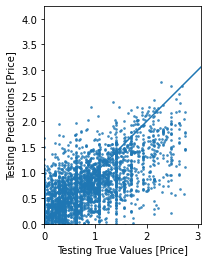

In [31]:
test_predictions = model.predict(normed_test_data).flatten()
print(len(test_predictions))
plt.scatter(test_labels, test_predictions,alpha=0.7,s=3)
plt.xlabel('Testing True Values [Price]')
plt.ylabel('Testing Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-10, 10], [-10, 10]) 

6969


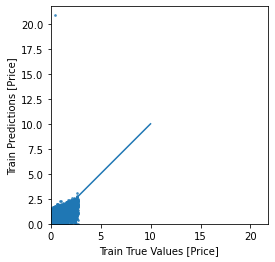

In [35]:
train_predictions = model.predict(normed_train_data).flatten()
print(len(test_predictions))
plt.scatter(train_labels, train_predictions,alpha=0.7,s=3)
plt.xlabel('Train True Values [Price]')
plt.ylabel('Train Predictions [Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.xlim()[1]])
_ = plt.plot([-10, 10], [-10, 10])

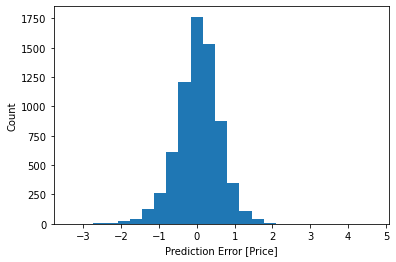

In [33]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Price]")
_ = plt.ylabel("Count")

In [34]:
y_test_pred = model.predict(normed_test_data)
y_train_pred = model.predict(normed_train_data)
print("Training MSE:", round(mean_squared_error(train_labels, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(test_labels, y_test_pred),4))
print("\nTraining r2:", round(r2_score(train_labels, y_train_pred),4))
print("Validation r2:", round(r2_score(test_labels, y_test_pred),4))

Training MSE: 0.2868
Validation MSE: 0.3263

Training r2: 0.7132
Validation r2: 0.6778
